### Pip Install the Necessary Libraries

In [ ]:
!pip install pennylane -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 38.9 MB/s eta 0:00:00


### Importing all the Necessary Libraries

In [ ]:
from PIL import Image
import librosa
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import roc_curve, auc,confusion_matrix,classification_report
import tensorflow as tf
from tensorflow.keras.utils import custom_object_scope
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow.keras.applications import MobileNetV3Large,MobileNetV3Small
from IPython.display import Audio,display
import shutil
import librosa
import pennylane as qml
import os
import numpy as np

### Set Global Variables

In [ ]:
tf.get_logger().setLevel('ERROR')

In [ ]:
# Set the path to the original directory containing 10 folders
original_directory = "/home/siddhant/ESC-10"

# Set the paths for the train and valid directories
train_directory = "/home/siddhant/ESC-10/train"
valid_directory = "/home/siddhant/ESC-10/valid"

# Create train and valid directories if they don't exist
os.makedirs(train_directory, exist_ok=True)
os.makedirs(valid_directory, exist_ok=True)

In [ ]:
n_qubits = 4
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}
dev = qml.device("default.qubit", wires=n_qubits)

### Curating a Quantum Layer via Pennylane

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [ ]:
@qml.qnode(dev)
def quantum_net(inputs, weights):
    """
    The variational quantum circuit.
    """

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(inputs)

    # Sequence of trainable variational layers
    for k in range(n_layers):
        entangling_layer(n_qubits)
        RY_layer(weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

### Curating the Hybrid Quantum-Classical Model Architecture

In [ ]:
# Step 1: Create the MobileNetV3Large base model
base_model = MobileNetV3Large(include_top=True, weights="imagenet")

# Step 2: Remove the last layer of the base model
base_model.layers.pop()

# Step 3: Freeze the remaining layers
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Define the rest of your model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=train_data.shape[1:]),
    tf.keras.layers.Conv2D(3, kernel_size=(1, 1), activation='linear'),  # Convert grayscale to RGB
    base_model,
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(4, activation="elu"),
    qml.qnn.KerasLayer(quantum_net, weight_shapes, output_dim=n_qubits),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

### Randomized Forward Pass for Weight Initialization

In [ ]:
random_input = np.random.rand(1, 128, 128, 1)
model.predict(random_input)

### Loading the Actual Saved Weights

In [ ]:
# Load the model
custom_objects = {'KerasLayer': qml.qnn.KerasLayer(quantum_net, weight_shapes,output_dim=n_qubits)}
with custom_object_scope(custom_objects):
    model.load_weights("final.h5")

### Performing Post-Training Quantization of Each Layer & Saving The Model

In [ ]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        layer.kernel = tf.quantization.quantize_and_dequantize_v2(layer.kernel, 0.0, 1.0)

In [1]:
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 3)       6         
                                                                 
 MobilenetV3large (Functiona  (None, 1000)             5507432   
 l)                                                              
                                                                 
 dense_44 (Dense)            (None, 1024)              1024      
                                                                 
 dense_45 (Dense)            (None, 512)               512       
                                                                 
 dense_46 (Dense)            (None, 256)               256       
                                                                 
 dense_47 (Dense)            (None, 4)                 4         
                                                     

In [ ]:
model.save_weights("final_quantized.h5")

***Model Size Reduces from 29MB to 22MB making it more efficient***

### Post Quantization Analysis -  Testing

In [8]:
with open("data.pkl", 'rb') as f:
    # Load the data dictionary from the pickle file
    combined_data,combined_labels = pickle.load(f)
combined_predictions = model.predict(combined_data)

13/13 [==============================] - 50s 4s/step


In [ ]:
converted_predictions = list()

for pred_array in combined_predictions:
    output_array = np.zeros_like(pred_array)
    output_array[np.argmax(pred_array)] = 1
    converted_predictions.append(output_array)

converted_predictions = np.array(converted_predictions)

In [ ]:
final_labels = np.argmax(combined_labels,axis=1)
final_predictions = np.argmax(converted_predictions,axis=1)

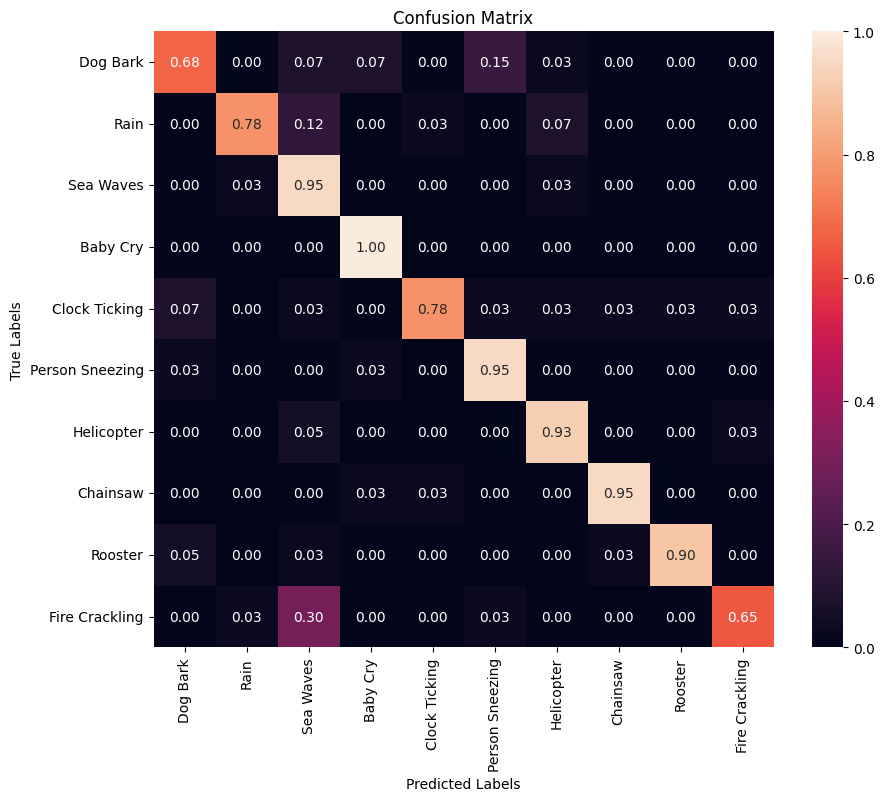

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Example usage
esc_10_classes = [
    'Dog Bark',
    'Rain',
    'Sea Waves',
    'Baby Cry',
    'Clock Ticking',
    'Person Sneezing',
    'Helicopter',
    'Chainsaw',
    'Rooster',
    'Fire Crackling'
]


plot_confusion_matrix(final_labels, final_predictions, esc_10_classes)

In [ ]:
print(classification_report(final_labels, final_predictions))

              precision    recall  f1-score   support

           0       0.82      0.68      0.74        40
           1       0.94      0.78      0.85        40
           2       0.61      0.95      0.75        40
           3       0.89      1.00      0.94        40
           4       0.94      0.78      0.85        40
           5       0.83      0.95      0.88        40
           6       0.86      0.93      0.89        40
           7       0.95      0.95      0.95        40
           8       0.97      0.90      0.94        40
           9       0.93      0.65      0.76        40

    accuracy                           0.85       400
   macro avg       0.87      0.86      0.85       400
weighted avg       0.87      0.85      0.85       400



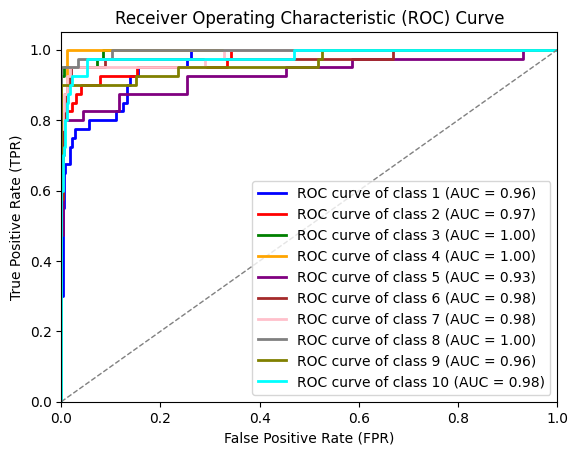

In [ ]:
true_labels = final_labels
predicted_probs = combined_predictions

# Binarize the true labels
n_classes = 10
binarized_labels = label_binarize(true_labels, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class %d (AUC = %0.2f)' % (i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()